In [1]:
import pathlib
from datetime import datetime
from typing import Optional

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import keras

from qrennd import get_model, Config, Layout
from qrennd.layouts.plotter import plot

2023-01-02 22:50:44.645467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext tensorboard

In [3]:
def get_syndromes(anc_meas: xr.DataArray) -> xr.DataArray:
    syndromes = anc_meas ^ anc_meas.shift(qec_round=1, fill_value=0)
    syndromes.name = "syndromes"
    return syndromes


def get_defects(
    syndromes: xr.DataArray, frame: Optional[xr.DataArray] = None
) -> xr.DataArray:
    shifted_syn = syndromes.shift(qec_round=1, fill_value=0)

    if frame is not None:
        shifted_syn[dict(qec_round=0)] = frame

    defects = syndromes ^ shifted_syn
    defects.name = "defects"
    return defects


def get_final_defects(
    syndromes: xr.DataArray,
    proj_syndrome: xr.DataArray,
) -> xr.DataArray:
    last_syndrome = syndromes.isel(qec_round=-1)
    proj_anc = proj_syndrome.anc_qubit

    final_defects = last_syndrome.sel(anc_qubit=proj_anc) ^ proj_syndrome
    final_defects.name = "final_defects"
    return final_defects


def preprocess_data(dataset, proj_mat):
    syndromes = get_syndromes(dataset.anc_meas)
    defects = get_defects(syndromes)

    proj_syndrome = (dataset.data_meas @ proj_mat) % 2
    final_defects = get_final_defects(syndromes, proj_syndrome)

    init_states = dataset.init_state.sum(dim="data_qubit") % 2
    log_states = dataset.data_meas.sum(dim="data_qubit") % 2

    labels = log_states.astype(int) ^ init_states

    #inputs = dict(defects=defects.data, final_defects=final_defects.data)
    #inputs = dict(defects=syndromes.data, final_defects=dataset.data_meas.data)
    inputs = dict(defects=dataset.anc_meas.data, final_defects=dataset.data_meas.data)
    outputs = labels.data

    return inputs, outputs

# Load the datasets

In [4]:
NOTEBOOK_DIR = pathlib.Path.cwd() # define the path where the notebook is placed.

LAYOUT_DIR = NOTEBOOK_DIR / "layouts"
if not LAYOUT_DIR.exists():
    raise ValueError("Layout directory does not exist.")

CONFIG_DIR = NOTEBOOK_DIR / "configs"
if not CONFIG_DIR.exists():
    raise ValueError("Config directory does not exist.")

# The train/dev/test data directories are located in the local data directory
TRAIN_DATA_DIR = NOTEBOOK_DIR / "data/train"
if not TRAIN_DATA_DIR.exists():
    raise ValueError("Train data directory does not exist.")

DEV_DATA_DIR = NOTEBOOK_DIR / "data/dev"
if not DEV_DATA_DIR.exists():
    raise ValueError("Dev data directory does not exist.")

TEST_DATA_DIR = NOTEBOOK_DIR / "data/test"
if not TEST_DATA_DIR.exists():
    raise ValueError("Test data directory does not exist.")

cur_datetime = datetime.now()
datetime_str = cur_datetime.strftime("%Y%m%d-%H%M%S")
LOG_DIR = NOTEBOOK_DIR / f".logs/{datetime_str}"
LOG_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
LAYOUT_FILE = "d3_layout.yaml"
layout = Layout.from_yaml(LAYOUT_DIR / LAYOUT_FILE)

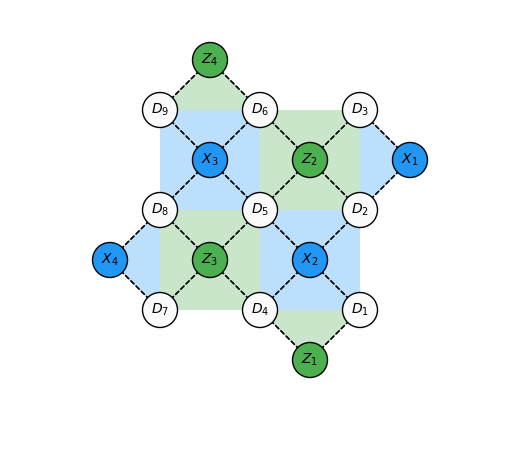

In [7]:
fig, ax = plt.subplots(dpi=100)
plot(layout, label_qubits=True, draw_patches=True, axis=ax)
plt.tight_layout()
plt.show()

In [8]:
proj_mat = layout.projection_matrix(stab_type="z_type")

/Users/boris/Projects/decoders/qrennd/qrennd/layouts/layout.py:93: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(self.graph)


In [30]:
CONFIG_FILE = "base_config.yaml"
config = Config.from_yaml(CONFIG_DIR / CONFIG_FILE)

In [31]:
train_dataset = xr.load_dataset(
    TRAIN_DATA_DIR / "d3_surf_code_seq_round_state_0_shots_1000000_rounds_40.nc"
)
train_input, train_output = preprocess_data(train_dataset, proj_mat)

dev_dataset = xr.load_dataset(
    DEV_DATA_DIR / "d3_surf_code_seq_round_state_0_shots_20000_rounds_40.nc"
)
dev_input, dev_output = preprocess_data(dev_dataset, proj_mat)

In [33]:
num_rounds = train_dataset.qec_round.size
num_anc = train_dataset.anc_qubit.size

num_final_anc = proj_mat.anc_qubit.size

In [38]:
model = get_model(
    defects_shape=(num_rounds, num_anc),
    final_defects_shape=(9, ),
    config=config,
)

In [39]:
model.summary()

Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 defects (InputLayer)           [(None, 40, 8)]      0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 40, 32)       5248        ['defects[0][0]']                
                                                                                                  
 dropout_LSTM_1 (Dropout)       (None, 40, 32)       0           ['LSTM_1[0][0]']                 
                                                                                                  
 LSTM_2 (LSTM)                  (None, 32)           8320        ['dropout_LSTM_1[0][0]']         
                                                                                      

# Training

In [40]:
# %tensorboard --logdir={LOG_DIR}

In [41]:
tensorboard = keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

model.fit(
    x=train_input,
    y=train_output,
    validation_data=[dev_input, dev_output],
    batch_size=64,
    epochs=5,
    callbacks=[
        tensorboard,
    ],
)

Epoch 1/5
15625/15625 [==============================] - 294s 18ms/step - loss: 0.8663 - main_output_loss: 0.5460 - aux_output_loss: 0.6388 - main_output_accuracy: 0.7208 - aux_output_accuracy: 0.5708 - val_loss: 0.7234 - val_main_output_loss: 0.4224 - val_aux_output_loss: 0.5997 - val_main_output_accuracy: 0.8619 - val_aux_output_accuracy: 0.6168
Epoch 2/5
15625/15625 [==============================] - 319s 20ms/step - loss: 0.7785 - main_output_loss: 0.4845 - aux_output_loss: 0.5859 - main_output_accuracy: 0.7676 - aux_output_accuracy: 0.6185 - val_loss: 0.6818 - val_main_output_loss: 0.3981 - val_aux_output_loss: 0.5652 - val_main_output_accuracy: 0.8687 - val_aux_output_accuracy: 0.6299
Epoch 3/5
15625/15625 [==============================] - 287s 18ms/step - loss: 0.7775 - main_output_loss: 0.4839 - aux_output_loss: 0.5850 - main_output_accuracy: 0.7688 - aux_output_accuracy: 0.6218 - val_loss: 0.6809 - val_main_output_loss: 0.3977 - val_aux_output_loss: 0.5642 - val_main_output_a

In [43]:
test_dataset = xr.load_dataset(
    TEST_DATA_DIR / "d3_surf_code_seq_round_state_0_shots_20000_rounds_20.nc"
)
test_input, test_output = preprocess_data(test_dataset, proj_mat)

In [44]:
eval_output = model.evaluate(x=test_input, y=test_output, batch_size=64)

313/313 [==============================] - 3s 5ms/step - loss: 0.4979 - main_output_loss: 0.2909 - aux_output_loss: 0.4116 - main_output_accuracy: 0.9097 - aux_output_accuracy: 0.7902


In [46]:
test_dataset = xr.load_dataset(
    TEST_DATA_DIR / "d3_surf_code_seq_round_state_0_shots_20000_rounds_20_v2.nc"
)
test_input, test_output = preprocess_data(test_dataset, proj_mat)

In [47]:
eval_output = model.evaluate(x=test_input, y=test_output, batch_size=64)

313/313 [==============================] - 2s 5ms/step - loss: 0.1178 - main_output_loss: 0.0680 - aux_output_loss: 0.0974 - main_output_accuracy: 0.9932 - aux_output_accuracy: 0.9890


In [48]:
layout.param("role", "D3")

AttributeError: 'Layout' object has no attribute '_qubit_info'

In [58]:
layout.graph.nodes["D3"]["role"] = "data"

In [103]:
LAYOUT_FILE = "d3_layout.yaml"
layout = Layout.from_yaml(LAYOUT_DIR / LAYOUT_FILE)

In [104]:
from collections import deque

In [115]:
def get_shift(direction):
    if direction in ("south", "west"):
        return -1
    return 1

nodes = list(layout.graph.nodes)
init_node = nodes.pop()
init_coord = (0, 0)

set_nodes = set()
queue = deque()

queue.appendleft((init_node, init_coord))
while queue:
    node, coords = queue.pop()

    layout.graph.nodes[node]["coords"] = coords
    set_nodes.add(node)

    for _, nbr_node, ord_dir in layout.graph.edges(node, data="direction"):
        if nbr_node not in set_nodes:
            card_dirs = ord_dir.split("_")
            shifts = tuple(map(get_shift, card_dirs))
            nbr_coords = tuple((coord + shift for coord, shift in zip(coords, shifts)))
            queue.appendleft((nbr_node, nbr_coords))


In [116]:
list(layout.graph.nodes(data="coords"))

[('D1', (3, -5)),
 ('D2', (3, -3)),
 ('D3', (3, -1)),
 ('D4', (1, -5)),
 ('D5', (1, -3)),
 ('D6', (1, -1)),
 ('D7', (-1, -5)),
 ('D8', (-1, -3)),
 ('D9', (-1, -1)),
 ('X1', (4, -2)),
 ('X2', (2, -4)),
 ('X3', (0, -2)),
 ('X4', (-2, -4)),
 ('Z1', (2, -6)),
 ('Z2', (2, -2)),
 ('Z3', (0, -4)),
 ('Z4', (0, 0))]

In [94]:
ord_dir = "north_west"
card_dirs = ord_dir.split("_")

In [100]:
queue = deque()
queue.append(("D1", (0, 0)))

In [102]:
queue.pop()

('D1', (0, 0))

In [93]:
for _, nbr_node, edge_dir in layout.graph.edges("D4", data="direction"):
    print(nbr_node, edge_dir)

Z1 north_west
X2 north_east
Z3 south_east


In [76]:
while queue:
    print(queue.popleft())

D1
D2
D3
D4
D5
D6
D7
D8
D9
X1
X2
X3
X4
Z1
Z2
Z3
Z4


In [78]:
layout.graph.

KeyError: 0

In [7]:
a = (0, 2)
b = (1, -1)

In [12]:
c = map(lambda x: x, (1, -1))

In [11]:
c

[1, -1]

In [16]:
tuple(map(sum, zip(a, c)))

()